## 1. Učitavanje potrebnih paketa

In [1]:
# Standardne biblioteke
import sys
sys.path.append('../../')

import itertools

# Analiza podataka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinRL i stable_baselines3 za strojno učenje i trgovanje
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_primo_trading.env_primo_default import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure

# Konfiguracijski fajlovi i pomoćne funkcije iz FinRL
from finrl.config import INDICATORS
from finrl.main import check_and_make_directories

# Omogućavanje prikaza grafikona unutar Jupyter bilježnice
%matplotlib inline

TRAINED_MODEL_DIR = 'files/models_PORTFOLIO'
RESULTS_DIR = 'files/results_PORTFOLIO'
DATA_DIR = 'files/data_PORTFOLIO'

# Provjera i kreiranje direktorija
check_and_make_directories([TRAINED_MODEL_DIR, DATA_DIR])

## 2. Dohvat podataka

Imamo klasu nazvanu YahooDownloader koja koristi yfinance za dohvaćanje podataka s Yahoo Finance.

U YahooDownloader-u FinRL-a, modificirali smo okvir podataka u oblik koji je pogodan za daljnju obradu podataka. Koristimo prilagođenu zatvarajuću cijenu umjesto zatvarajuće cijene i dodajemo stupac koji predstavlja dan u tjednu (0-4 što odgovara ponedjeljku-petku).

In [2]:
# Intervali za trening i trgovanje
TRAIN_START_DATE = '2021-09-01'
TRAIN_END_DATE = '2023-12-31'
TRADE_START_DATE = '2024-01-01'
TRADE_END_DATE = '2024-07-31'  

In [3]:
# Preuzimamo sve podatke
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list = ["AAPL", "NFLX", "MSFT", "CRM", "AMZN"]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (3655, 8)


In [4]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2021-09-01,152.830002,154.979996,152.339996,149.998215,80313700,AAPL,2
1,2021-09-01,174.820007,176.350006,173.761993,173.949997,72598000,AMZN,2
2,2021-09-01,266.269989,273.260010,265.589996,267.553497,7189000,CRM,2
3,2021-09-01,302.869995,305.190002,301.489990,294.250458,18983800,MSFT,2
4,2021-09-01,569.000000,591.000000,569.000000,582.070007,5626200,NFLX,2


## 3. Procesiranje podataka

Koristimo definiranu klasu FeatureEngineer pomoću koje radimo procesiranje podataka i dodavanje tehničkih indikatora.

Opcija use_vix uključuje VIX indeks, poznat kao "indeks straha", koji predstavlja očekivanu volatilnost tržišta dionica temeljenu na opcijama S&P 500 indeksa. VIX pomaže modelu da razumije tržišnu nesigurnost, s višim vrijednostima koje ukazuju na veću nesigurnost.

Opcija use_turbulence uključuje indeks turbulencije, koji mjeri neobične tržišne fluktuacije i služi kao pokazatelj rizika i tržišnih šokova. Koristan je za identifikaciju perioda visoke volatilnosti, pomažući modelu da se prilagodi financijskim krizama.

Inače dosta zgodna klasa koja sadrži korisne metode za obradu financijskih podataka i može se primjeniti u brojne druge svrhe.

In [5]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (730, 8)
Successfully added vix


Successfully added turbulence index


In [6]:
# Stvara listu jedinstvenih oznaka dionica (tickers) iz stupca 'tic' DataFrame-a 'processed'.
list_ticker = processed["tic"].unique().tolist()

# Stvara listu datuma između najranijeg i najkasnijeg datuma u DataFrame-u 'processed', pretvara ih u stringove.
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))

# Stvara kombinacije svih datuma i oznaka dionica koristeći kartezijev produkt.
combination = list(itertools.product(list_date,list_ticker))

# Stvara novi DataFrame 'processed_full' s kolonama "date" i "tic", koji sadrži sve kombinacije datuma i oznaka dionica.
# Spaja taj DataFrame s originalnim DataFrame-om 'processed' na temelju kolona "date" i "tic", koristeći 'left' spajanje.
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")

# Filtrira 'processed_full' DataFrame da sadrži samo one retke čiji su datumi prisutni u originalnom DataFrame-u 'processed'.
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Sortira 'processed_full' DataFrame po datumu i oznaci dionica.
processed_full = processed_full.sort_values(['date','tic'])

# Zamjenjuje sve nedostajuće vrijednosti (NaN) s 0 u DataFrame-u 'processed_full'.
processed_full = processed_full.fillna(0)

In [7]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-09-01,AAPL,152.830002,154.979996,152.339996,149.998215,80313700.0,2.0,0.0,152.144461,148.973184,100.0,66.666667,100.0,149.998215,149.998215,16.110001,0.0
1,2021-09-01,AMZN,174.820007,176.350006,173.761993,173.949997,72598000.0,2.0,0.0,152.144461,148.973184,100.0,66.666667,100.0,173.949997,173.949997,16.110001,0.0
2,2021-09-01,CRM,266.269989,273.260010,265.589996,267.553497,7189000.0,2.0,0.0,152.144461,148.973184,100.0,66.666667,100.0,267.553497,267.553497,16.110001,0.0
3,2021-09-01,MSFT,302.869995,305.190002,301.489990,294.250458,18983800.0,2.0,0.0,152.144461,148.973184,100.0,66.666667,100.0,294.250458,294.250458,16.110001,0.0
4,2021-09-01,NFLX,569.000000,591.000000,569.000000,582.070007,5626200.0,2.0,0.0,152.144461,148.973184,100.0,66.666667,100.0,582.070007,582.070007,16.110001,0.0


In [8]:
# Pripremamo trening i trade set sukladno definiranim datumima
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2930
720


In [9]:
# Spremamo podatke
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

## 4. Priprema environmenta

stock_dimension predstavlja broj jedinstvenih dionica u skupu podataka. Ova vrijednost se koristi za određivanje koliko različitih dionica model može trgovati.

state_space označava ukupnu veličinu prostora stanja koji model koristi za donošenje odluka. Prostor stanja uključuje trenutne podatke o dionicama (kao što su cijene i tehnički indikatori) i informacije o trenutnom portfelju (kao što su broj dionica koje posjeduje). Veličina prostora stanja određena je formulom koja uzima u obzir broj dionica i broj tehničkih indikatora.

In [10]:
# Izračunavamo dimenziju (broj jedinstvenih dionica) iz DataFrame-a 'train'.
stock_dimension = len(train.tic.unique())

# Izračunavamo veličinu stanja na temelju dimenzije i broja tehničkih indikatora.
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 51


In [11]:
# Stvara liste troškova kupnje i prodaje za svaku dionicu.
buy_cost_list = sell_cost_list = [0] * stock_dimension

# Inicijalizira broj dionica za svaku dionicu na 0.
num_stock_shares = [0] * stock_dimension

e_train_gym je instanca klase StockTradingEnv, koja predstavlja okruženje za trgovanje. Ovo okruženje koristi podatke i parametre definirane za simulaciju tržišta dionica. Model uči kako trgovati unutar ovog okruženja, pokušavajući maksimizirati ukupnu nagradu (profit) kroz seriju trgovačkih odluka.

env_train dobiva se pozivom metode get_sb_env() na instanci e_train_gym. Ova metoda vraća okruženje kompatibilno s bibliotekom Stable Baselines 3, koja se koristi za implementaciju algoritama pojačanog učenja. Drugi povratni element, koji se ovdje ignorira (_), može se koristiti za dodatne informacije ili funkcionalnosti koje pruža okruženje.

In [12]:
# Definira argumente za okruženje trgovanja.
env_kwargs = {
    "hmax": 1000,  # Maksimalni broj dionica koje se mogu kupiti ili prodati u jednoj transakciji.
    "initial_amount": 100000,  # Početni iznos kapitala.
    "num_stock_shares": num_stock_shares,  # PPočetni broj dionica svake dionice u portfelju, inicijalno postavljen na 0.
    "buy_cost_pct": buy_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "sell_cost_pct": sell_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "state_space": state_space,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "stock_dim": stock_dimension,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "tech_indicator_list": INDICATORS,  # Lista tehničkih indikatora koji će se koristiti za analizu stanja tržišta.
    "action_space": stock_dimension,  # Veličina prostora akcija, odnosno, broj različitih akcija koje model može izvršiti.
    "reward_scaling": 1e-2  # Faktor skaliranja za nagradu, koristi se za prilagodbu veličine nagrade kako bi se olakšalo učenje.
}

# Kreira okruženje za treniranje.
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Dohvaća okruženje pogodno za Stable Baselines i neiskorišteni objekt.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5. Trening DRL agenata

Ovdje su algoritmi dubokog pojačanog učenja (DRL) iz biblioteke Stable Baselines 3. Radi se o biblioteci koja je implementirala popularne DRL algoritme koristeći PyTorch.

Kao zamjena mogu se koristiti biblioteke ElegantRL i Ray RLlib.

In [13]:
# Kreira instancu DRL agenta s predanim okruženjem za treniranje.
agent = DRLAgent(env = env_train)

# Postavljanje odgovarajućih vrijednosti na 'True' za algoritme koje želite koristiti
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Trening 5 različitih DRL agenata (A2C, DDPG, PPO, TD3, SAC)

#### Agent 1: A2C

In [14]:
# Ponovno se kreira instanca DRL agenta s predanim okruženjem (nije potrebno ponovno raditi, ali zbog lakših uputa neka stoji)
agent = DRLAgent(env = env_train)
# Dohvaća model A2C pomoću metode get_model
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # Postavljanje loggera za praćenje i zapisivanje informacija tijekom treniranja
  tmp_path = RESULTS_DIR + '/a2c'
  # Konfigurira novi logger koji će ispisivati informacije na standardni izlaz, zapisivati u CSV datoteku i TensorBoard
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Postavlja novi logger za model A2C.
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to files/results_PORTFOLIO/a2c


In [15]:
# Trenira model A2C s definiranim ukupnim brojem vremenskih koraka, samo ako je if_using_a2c postavljen na True.
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 1003      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -7.11     |
|    explained_variance | -0.115    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -29.6     |
|    reward             | 7.4248123 |
|    std                | 1         |
|    value_loss         | 74.4      |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 1067        |
|    iterations         | 200         |
|    time_elapsed       | 0           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -7.15       |
|    explained_variance | -0.0321     |
|    learning_rate      | 0.0007

In [16]:
# Sprema trenirani model A2C u definirani direktorij, samo ako je if_using_a2c postavljen na True.
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

#### Agent 2: DDPG

In [17]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to files/results_PORTFOLIO/ddpg


In [18]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 585, episode: 90
begin_total_asset: 100000.00
end_total_asset: 83844.06
total_reward: -16155.94
total_cost: 0.00
total_trades: 2925
Sharpe: 0.135
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 167        |
|    time_elapsed    | 13         |
|    total_timesteps | 2344       |
| train/             |            |
|    actor_loss      | 24.3       |
|    critic_loss     | 565        |
|    learning_rate   | 0.001      |
|    n_updates       | 2243       |
|    reward          | -6.2102103 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 167        |
|    time_elapsed    | 27         |
|    total_timesteps | 4688       |
| train/             |            |
|    actor_loss      | 17.7       |
|    critic_loss     | 68         |
|    learning_rate   | 0.001      |
|    n_updates       

In [19]:

trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO

In [20]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to files/results_PORTFOLIO/ppo


In [21]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 1813       |
|    iterations      | 1          |
|    time_elapsed    | 1          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -23.248358 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1651       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00648469 |
|    clip_fraction        | 0.0514     |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.09      |
|    explained_variance   | -0.00151   |
|    learning_rate        | 0.00025    |
|    loss                 | 2.02e+03   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0117    |
|    reward         

In [22]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

#### Agent 4: TD3

In [23]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to files/results_PORTFOLIO/td3


In [24]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

day: 585, episode: 520
begin_total_asset: 100000.00
end_total_asset: 83844.06
total_reward: -16155.94
total_cost: 0.00
total_trades: 2340
Sharpe: 0.135
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 156        |
|    time_elapsed    | 14         |
|    total_timesteps | 2344       |
| train/             |            |
|    actor_loss      | 65.1       |
|    critic_loss     | 452        |
|    learning_rate   | 0.001      |
|    n_updates       | 2243       |
|    reward          | -6.2102103 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 176        |
|    time_elapsed    | 26         |
|    total_timesteps | 4688       |
| train/             |            |
|    actor_loss      | 84.3       |
|    critic_loss     | 143        |
|    learning_rate   | 0.001      |
|    n_updates      

In [25]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

#### Agent 5: SAC

In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to files/results_PORTFOLIO/sac


In [27]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 115       |
|    time_elapsed    | 20        |
|    total_timesteps | 2344      |
| train/             |           |
|    actor_loss      | 73        |
|    critic_loss     | 363       |
|    ent_coef        | 0.117     |
|    ent_coef_loss   | 19.6      |
|    learning_rate   | 0.0001    |
|    n_updates       | 2243      |
|    reward          | -8.243012 |
----------------------------------
day: 585, episode: 610
begin_total_asset: 100000.00
end_total_asset: 125162.26
total_reward: 25162.26
total_cost: 0.00
total_trades: 1809
Sharpe: 0.448
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 114       |
|    time_elapsed    | 40        |
|    total_timesteps | 4688      |
| train/             |           |
|    actor_loss      | 92.1      |
|    critic_loss     | 422       |
|    ent

In [28]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 6. Priprema za backtest

In [29]:
# Po potrebi učitavamo sporemnjene podatke ako smo restrartali proces (nije potrebno)
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [30]:
# Po potrebi učitavamo sporemnjene podatke o treningu agenata ako smo restrartali proces (nije potrebno)
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 7. Trgovanje (podatci izvan trening seta)

Ovdje sada za trgovanje koristimo trade skup podataka koji nikad nije bio korišten za trening. Dodatno sličnim pristupom bi mogli i dotrenirati postojeći spremljeni model.

Brojni hiperparametri, na primjer, stopa učenja, ukupan broj uzoraka za trening – utječu na proces učenja i obično se određuju testiranjem nekih varijacija.

In [31]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 51


In [32]:
buy_cost_list = sell_cost_list = [0] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2
}

Ovaj dio se odnosi se na korištenje dubokog pojačanog učenja (DRL) za simulaciju trgovanja u stvarnom vremenu koristeći prethodno trenirani model (u ovom slučaju, A2C). StockTradingEnv je okruženje koje simulira tržište dionica s obzirom na povijesne podatke, prag turbulencije (koji se koristi za određivanje volatilnosti tržišta), i 'VIX' kao pokazatelj rizika. Nakon inicijalizacije okruženja, koristi se metoda get_sb_env() za dohvaćanje okruženja i početne opservacije koje su kompatibilne sa Stable Baselines bibliotekom.

In [33]:
# Inicijalizacija okruženja za trgovanje s definiranim DataFrame-om 'trade', pragom turbulencije i pokazateljem rizika 'vix',
# zajedno s ostalim parametrima okruženja ('env_kwargs').
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Dohvaćanje okruženja kompatibilnog sa Stable Baselines i početne opservacije.
env_trade, obs_trade = e_trade_gym.get_sb_env()

Zatim se DRL agent koristi za predviđanje akcija trgovanja i promjene u vrijednosti računa na temelju treniranog modela. To omogućuje evaluaciju performansi modela u scenariju izvan uzorka, pružajući uvid u to kako bi model mogao performirati u stvarnim trgovačkim uvjetima. Ako je odabrana upotreba A2C algoritma (kao što je indicirano varijablom if_using_a2c), provodi se predviđanje; u suprotnom, rezultat se postavlja na None.

In [34]:
# Korištenje DRL agenta za predviđanje koristeći trenirani model 'trained_a2c' i definirano okruženje trgovanja 'e_trade_gym'.
# Rezultati su dva DataFrame-a: 'df_account_value_a2c' s vrijednostima računa i 'df_actions_a2c' s akcijama koje su poduzete,
# ako je 'if_using_a2c' postavljen na True; inače se vraća (None, None).
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [35]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [36]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [37]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [38]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


## 8. Mean Variance optimizacija

Optimizacija srednje varijance je klasična strategija upravljanja portfeljem. Ovdje prolazimo kroz cijeli proces da bismo izvršili optimizaciju srednje varijance i dodali je kao osnovu za usporedbu (benchmark).

Naredni kod implementira optimizaciju srednje varijance (MVO) za upravljanje portfeljem. Počinje pripremom podataka za izračun težina MVO, sortiranjem podataka i izvlačenjem zatvarajućih cijena. Zatim koristi te podatke za izračunavanje dnevnih povrata dionica, te na temelju toga izračunava prosječne povrate i kovarijacijsku matricu povrata. Ovi statistički podaci su temelj za daljnje analize i odluke u upravljanju portfeljem, pružajući uvid u očekivane povrate i rizike povezane s različitim dionicama u portfelju.

Obrađujemo DataFrame za izračun težina srednje varijance.

In [39]:
# Funkcija za pripremu DataFrame-a za izračun težina optimizacije srednje varijance (MVO)
def process_df_for_mvo(df):
  # Sortira DataFrame po datumu i oznaci dionice, a zatim selektira samo relevantne stupce
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  # Uzima podskup podataka za prvu dimenziju dionica
  fst = df.iloc[0:stock_dimension, :]
  # Izvlači popis oznaka dionica
  tic = fst['tic'].tolist()

  # Inicijalizira prazan DataFrame za MVO
  mvo = pd.DataFrame()

  # Postavlja početne vrijednosti težina na 0 za svaku dionicu
  for k in range(len(tic)):
    mvo[tic[k]] = 0

  # Popunjava DataFrame 'mvo' zatvarajućim cijenama za svaku dionicu po datumima
  for i in range(df.shape[0]//stock_dimension):
    n = df.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

In [40]:
# Funkcija za izračun povrata dionica na temelju njihovih cijena
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  # Inicijalizira matricu povrata.
  StockReturn = np.zeros([Rows-1, Columns]) 
  # Računa dnevni povrat za svaku dionicu
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):       # i: Daily Prices 
      StockReturn[i,j] = ((StockPrice[i+1, j] - StockPrice[i,j]) / StockPrice[i,j]) * 100 
      
  return StockReturn

In [41]:
# Primjena funkcije na trening i trade
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

# Pretvara TradeData u numpy niz
TradeData.to_numpy()

array([[184.93821716, 149.92999268, 255.39831543, 368.85409546,
        468.5       ],
       [183.5534668 , 148.47000122, 251.12055969, 368.58557129,
        470.26000977],
       [181.22233582, 144.57000732, 250.52227783, 365.94000244,
        474.67001343],
       [180.49507141, 145.24000549, 250.40261841, 365.75106812,
        474.05999756],
       [184.85852051, 149.1000061 , 260.12475586, 372.65335083,
        485.02999878],
       [184.44010925, 151.36999512, 260.59344482, 373.74737549,
        482.08999634],
       [185.48616028, 153.72999573, 263.37545776, 380.68939209,
        478.32998657],
       [184.88841248, 155.17999268, 270.60473633, 382.53930664,
        492.23001099],
       [185.21716309, 154.61999512, 271.15316772, 386.35842896,
        492.16000366],
       [182.93582153, 153.16000366, 268.42102051, 388.14862061,
        481.23999023],
       [181.9894104 , 151.71000671, 270.6645813 , 387.35296631,
        480.32998657],
       [187.91691589, 153.5       , 273.675

In [42]:
# Izračunava povrat po imovini
arStockPrices = np.asarray(StockData)
[Rows, Cols] = arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

# Izračunava prosječne povrate i kovarijacijsku matricu povrata
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
# Postavlja preciznost za ispis rezultata.
np.set_printoptions(precision=3, suppress = True)

# Prikazuje prosječne povrate i kovarijacijsku matricu povrata
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.058 0.009 0.026 0.058 0.029]
Variance-Covariance matrix of returns
 [[ 3.196  2.806  2.532  2.43   2.778]
 [ 2.806  6.467  3.777  3.217  4.389]
 [ 2.532  3.777  5.972  2.839  3.961]
 [ 2.43   3.217  2.839  3.483  2.831]
 [ 2.778  4.389  3.961  2.831 11.177]]


### Korsitimo sada PyPortfolioOpt

In [43]:
# Učitavanje klase EfficientFrontier iz PyPortfolioOpt biblioteke
from pypfopt.efficient_frontier import EfficientFrontier

# Inicijalizacija objekta EfficientFrontier s prosječnim povratima i kovarijacijskom matricom povrata
# Ograničenja težine su postavljena tako da nijedna imovina ne može činiti više od 50% portfelja
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))

# Izračunavanje sirovih težina za maksimalni Sharpeov omjer
raw_weights_mean = ef_mean.max_sharpe()

# Čišćenje težina kako bi se zaokružile vrlo male težine na 0 i normalizirale ostale
cleaned_weights_mean = ef_mean.clean_weights()

# Pretvorba čistih težina u stvarne iznose ulaganja, pretpostavljajući početni kapital od 1,000,000
mvo_weights = np.array([100000 * cleaned_weights_mean[i] for i in range(5)])
print(mvo_weights)

# Izračunavanje cijene posljednje dionice u datasetu kako bi se odredile početne količine dionica.
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])

# Izračunavanje početnog portfelja množenjem iznosa ulaganja s posljednjom cijenom.
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
print(Initial_Portfolio)

# Izračunavanje vrijednosti portfelja koristeći trgovinske podatke i početne količine dionica.
Portfolio_Assets = TradeData @ Initial_Portfolio

# Stvaranje DataFrame-a s rezultatima optimizacije srednje varijance.
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
print(MVO_result)

[50000.     0.     0. 50000.     0.]
[260.685   0.      0.    133.691   0.   ]
                 Mean Var
2024-01-02   97523.244657
2024-01-03   97126.361298
2024-01-04   96164.980309
2024-01-05   95950.134321
2024-01-08   98010.396225
...                   ...
2024-07-23  117954.540334
2024-07-24  114141.313024
2024-07-25  112466.681938
2024-07-26  113505.867198
2024-07-29  113773.616554

[144 rows x 1 columns]


## 9. DJI indeks za usporedbu

Dodajemo DJI indeks koji koristimo kao benchmark za usporedbu s našim DRL modelima

In [44]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (145, 8)


In [45]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(100000), 
               how='outer', left_index=True, right_index=True).set_index('date')

## 10. Provodima backetinskg modela

In [46]:
# Postavljanje indeksa DataFrame-ova vrijednosti računa za svaku od DRL strategija, ako su odabrane.
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# Kreiranje praznog DataFrame-a za rezultate.
result = pd.DataFrame()

# Spajanje rezultata svih DRL strategija u jedan DataFrame, ako su odabrane.
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))

# Spajanje rezultata optimizacije srednje varijance i indeksa DJIA s glavnim rezultatima.
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_79119/3791775406.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [47]:
# Dodavanje imena stupaca na temelju odabranih strategija.
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('DJI') 
result.columns = col_name

In [48]:
# Prikazivanje rezultata
result.head()

,A2C,DDPG,PPO,TD3,SAC,Mean Var,DJI
date,,,,,,,
2024-01-02,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,97523.244657,100000.000000
2024-01-03,99252.234802,100373.422089,98327.397507,100373.422089,100373.422089,97126.361298,99244.737210
2024-01-04,97993.424072,101308.852875,98093.469299,101308.852875,101310.421738,96164.980309,99271.645408
2024-01-05,97600.701294,101179.589493,98046.682465,101179.589493,101179.761093,95950.134321,99339.972346
2024-01-08,99956.963806,103520.059753,101848.038208,103520.059753,103520.734802,98010.396225,99915.080709


### Ovdje plotiramo graf koji pokazuje ukupnu vrijednost portfolija korz vrijeme za pojedinu strategiju i benchmark

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

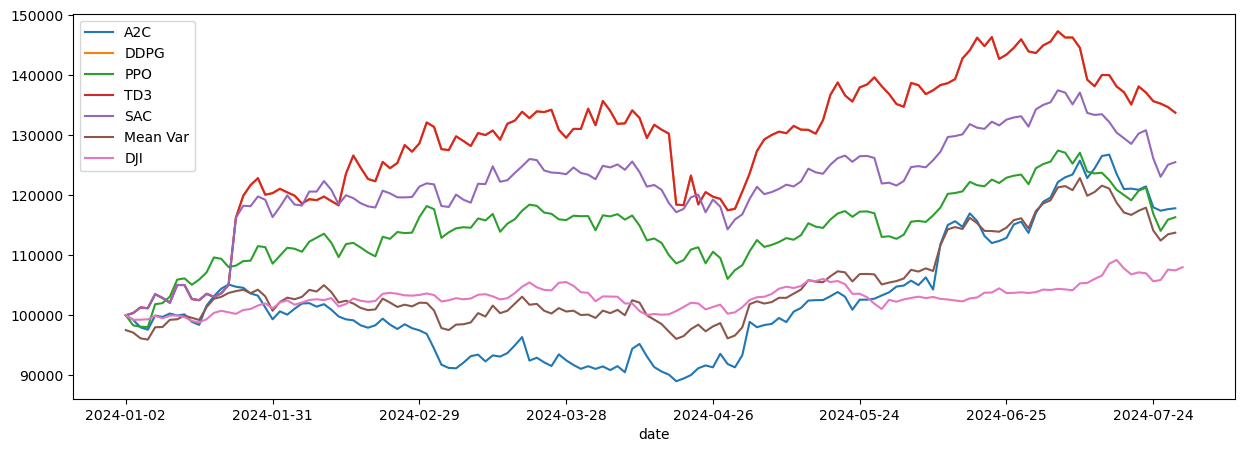

In [49]:
# Postavljanje veličine figure za grafikone i crtanje grafikona performansi strategija trgovanja.
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

Na temelju vrijednosti portfolija računamo dnevne povrate 

In [50]:
from pyfolio import timeseries
import pandas as pd

# Lista strategija za koje želite generirati statistike
strategies = ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC', "Mean Var", "DJI"]

for strategy in strategies:
    column_name = f'{strategy}'
    if column_name in result.columns:
        # Izračunavanje dnevnih povrata iz vrijednosti portfelja
        result[f'{strategy}_returns'] = result[column_name].pct_change()

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_79119/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_79119/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8w

In [51]:
result.head()

,A2C,DDPG,PPO,TD3,SAC,Mean Var,DJI,A2C_returns,DDPG_returns,PPO_returns,TD3_returns,SAC_returns,Mean Var_returns,DJI_returns
date,,,,,,,,,,,,,,
2024-01-02,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,97523.244657,100000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03,99252.234802,100373.422089,98327.397507,100373.422089,100373.422089,97126.361298,99244.737210,-0.007478,0.003734,-0.016726,0.003734,0.003734,-0.004070,-0.007553
2024-01-04,97993.424072,101308.852875,98093.469299,101308.852875,101310.421738,96164.980309,99271.645408,-0.012683,0.009320,-0.002379,0.009320,0.009335,-0.009898,0.000271
2024-01-05,97600.701294,101179.589493,98046.682465,101179.589493,101179.761093,95950.134321,99339.972346,-0.004008,-0.001276,-0.000477,-0.001276,-0.001290,-0.002234,0.000688
2024-01-08,99956.963806,103520.059753,101848.038208,103520.059753,103520.734802,98010.396225,99915.080709,0.024142,0.023132,0.038771,0.023132,0.023137,0.021472,0.005789


### Računamo povrate po odabranoj strategiji

In [52]:
# Pretpostavljamo da result DataFrame već sadrži vrijednosti portfelja za svaku strategiju
for strategy in strategies:
    # Provjerite postoji li strategija u DataFrame-u
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju
        returns = result[f'{strategy}_returns'].dropna()
        returns.index = pd.to_datetime(returns.index)

        # Izračunavanje statistika performansi za trenutnu strategiju
        perf_stats = timeseries.perf_stats(returns=returns, factor_returns=None, positions=None, transactions=None, turnover_denom="AGB")

        # Ispis statistika performansi
        print(f"==============Strategy Stats ({strategy})==============")
        print(perf_stats)
        print("\n")
    else:
        print(f"Strategija {strategy} nije pronađena u rezultatima.\n")


==============Strategy Stats (A2C)==============
Annual return          0.332925
Cumulative returns     0.178467
Annual volatility      0.241897
Sharpe ratio           1.307506
Calmar ratio           2.170969
Stability              0.406674
Max drawdown          -0.153353
Omega ratio            1.256950
Sortino ratio          2.207259
Skew                   1.007544
Kurtosis               3.935782
Tail ratio             1.112096
Daily value at risk   -0.029221
dtype: float64


==============Strategy Stats (DDPG)==============
Annual return          0.664234
Cumulative returns     0.337853
Annual volatility      0.300954
Sharpe ratio           1.842776
Calmar ratio           4.946243
Stability              0.651304
Max drawdown          -0.134291
Omega ratio            1.409611
Sortino ratio          2.997485
Skew                   0.446536
Kurtosis               8.849126
Tail ratio             1.312874
Daily value at risk   -0.035716
dtype: float64


==============Strategy Stats (PPO)=

### Plotiramo komulativne povrate za pojedinu strategiju

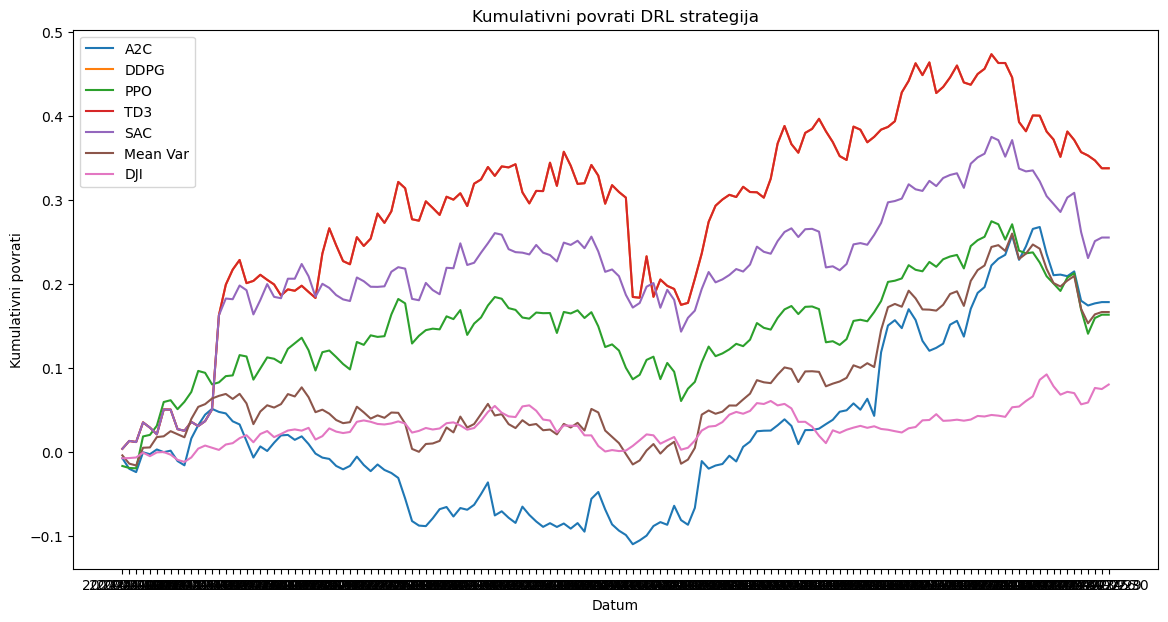

In [53]:
import matplotlib.pyplot as plt

# Postavljanje veličine figure za grafikon
plt.figure(figsize=(14, 7))

# Prolazak kroz svaku strategiju i crtanje njenih kumulativnih povrata
for strategy in strategies:
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju i pretvaranje u decimalni format ako je potrebno
        returns = result[f'{strategy}_returns'].dropna() + 1  # Dodaje 1 za korištenje cumprod()

        # Izračunavanje kumulativnih povrata
        cumulative_returns = returns.cumprod() - 1  # Oduzima 1 na kraju za prikazivanje pravog kumulativnog povrata

        # Plotiranje kumulativnih povrata
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)

# Dodavanje naslova i legende na grafikon
plt.title('Kumulativni povrati DRL strategija')
plt.legend()

# Postavljanje oznaka za x i y osi
plt.xlabel('Datum')
plt.ylabel('Kumulativni povrati')

# Prikazivanje grafikona
plt.show()


### Spremamo rezultate u CSV
Potrebno promjeniti za svakog agenta

In [54]:
import pickle

# Za ppo
with open('results/7. PORTFOLIO/finrl_df_account_value_ppo.pkl', 'wb') as f:
    pickle.dump(df_account_value_ppo, f)
    
# Za a2c
with open('results/7. PORTFOLIO/finrl_df_account_value_a2c.pkl', 'wb') as f:
    pickle.dump(df_account_value_a2c, f)

# Za ddpg
with open('results/7. PORTFOLIO/finrl_df_account_value_ddpg.pkl', 'wb') as f:
    pickle.dump(df_account_value_ddpg, f)

# Za td3
with open('results/7. PORTFOLIO/finrl_df_account_value_td3.pkl', 'wb') as f:
    pickle.dump(df_account_value_td3, f)

# Za sac
with open('results/7. PORTFOLIO/finrl_df_account_value_sac.pkl', 'wb') as f:
    pickle.dump(df_account_value_sac, f)

# Za mean var
with open('results/7. PORTFOLIO/finrl_mean_var.pkl', 'wb') as f:
    pickle.dump(MVO_result, f)

# Za dji
with open('results/7. PORTFOLIO/finrl_dji.pkl', 'wb') as f:
    pickle.dump(dji, f)